In [115]:
from scipy.optimize import curve_fit

from Triangulation import *
from Plots import *

# 3D Embedding

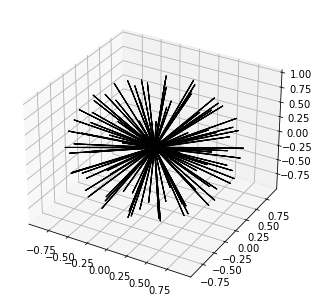

In [116]:
m = Manifold(200)
plot_triangulation_3d(m.adj)

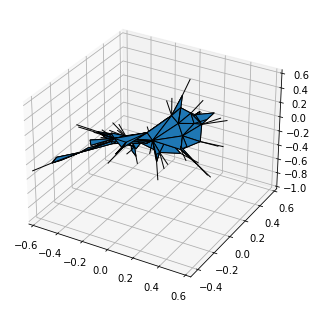

In [117]:
n_sweeps = 200
m.sweep(n_sweeps, 0.1, strategy=['ising', 'gravity'])
plot_triangulation_3d(m.adj)

In [118]:
is_sphere_triangulation(m.adj)

True

# Graph Representation

In [119]:
l2 = Manifold(4)
l2.sweep(1000)
adj = l2.adj
num_vert, vertex = vertex_list(adj)
edges = triangulation_edges(adj, vertex)
triangles = triangulation_triangles(adj, vertex)
G = nx.Graph(edges)

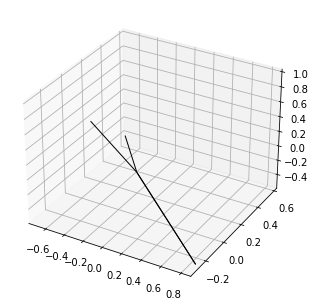

In [120]:
plot_triangulation_3d(l2.adj)

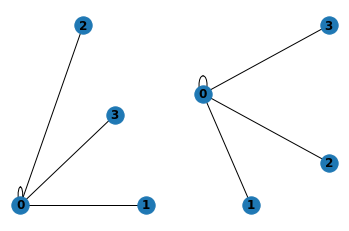

In [121]:
subax1 = plt.subplot(121)
nx.draw_planar(G, with_labels=True, font_weight='bold')
subax2 = plt.subplot(122)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

# Distance Profile and Haussdorff Dimension

In [122]:
eq_sweeps = 400
meas_sweeps = 10
n_measurements = 100

def make_profiles(beta, sizes, strategy=['gravity', 'ising'], eq_sweeps=eq_sweeps, n_measurements=n_measurements):
    mean_profiles = []
    for size in sizes:
        m = Manifold(size)
        m.sweep(eq_sweeps, beta=beta, strategy=strategy)
        profiles = []
        for _ in range(n_measurements):
            m.sweep(meas_sweeps, beta=beta, strategy=strategy)
            profiles.append(dist_prof(m.adj,15))
        mean_profiles.append([batch_estimate(data,np.mean,20) for data in np.transpose(profiles)])
        print(size)
    return np.array(mean_profiles)

def scale_profile(profiles, sizes, d):
    xs, ys = [], []
    for i, profile in enumerate(profiles):
        rvals = np.arange(len(profile))
        x = rvals/sizes[i]**d
        y = profile/sizes[i]**(1-d)
        xs.append(x), ys.append(y)
        # plt.plot(x, y)
    return np.array(xs), np.array(ys)

"""
plt.plot(rvals/sizes[i]**0.25,[y[0]/ sizes[i]**0.75 for y in profile])
plt.fill_between(rvals/sizes[i]**0.25,[(y[0]-y[1])/sizes[i]**0.75 for y in profile],
                 [(y[0]+y[1])/sizes[i]**0.75 for y in profile],alpha=0.2)
plt.legend(sizes,title="N")
plt.xlabel(r"$x = r / N^{1/d}$")
plt.ylabel(r"$N^{1/d-1}\,\mathbb{E}[\rho_T(r)]$")
plt.xlim(0,3)
plt.title("Finite-size scaling with Hausdorff dimension d=4")
plt.show()
"""


def plot_profiles(mean_profiles):
    for profile in mean_profiles:
        plt.plot([y[0] for y in profile])
        plt.fill_between(range(len(profile)),[y[0]-y[1] for y in profile],[y[0]+y[1] for y in profile],alpha=0.2)
    plt.legend(sizes,title="N")
    plt.xlabel("r")
    plt.ylabel(r"$\mathbb{E}[\rho_T(r)]$")
    plt.title("Distance profile")
    plt.show()

def overlay_profiles(profiles, ranges):
    for profile, range in zip(profiles, ranges):
        plt.plot(range, [y[0] for y in profile])
        #plt.fill_between(range, range(len(profile)), [y[0]-y[1] for y in profile], [y[0]+y[1] for y in profile], alpha=0.2)
    plt.legend(sizes,title="N")
    plt.xlabel("r")
    plt.ylabel(r"$\mathbb{E}[\rho_T(r)]$")
    plt.title("Distance profile")
    plt.show()

In [123]:
beta=0
sizes = np.array([2*int(i) for i in np.geomspace(10, 20, 3)])
profiles = make_profiles(0, sizes)

20
28
40


[[0.         0.4728708  0.94574161 1.41861241 1.89148322 2.36435402
  2.83722483 3.31009563 3.78296644 4.25583724 4.72870805 5.20157885
  5.67444965 6.14732046 6.62019126]
 [0.         0.43472087 0.86944174 1.30416262 1.73888349 2.17360436
  2.60832523 3.0430461  3.47776698 3.91248785 4.34720872 4.78192959
  5.21665046 5.65137134 6.08609221]
 [0.         0.39763536 0.79527073 1.19290609 1.59054146 1.98817682
  2.38581219 2.78344755 3.18108292 3.57871828 3.97635364 4.37398901
  4.77162437 5.16925974 5.5668951 ]]


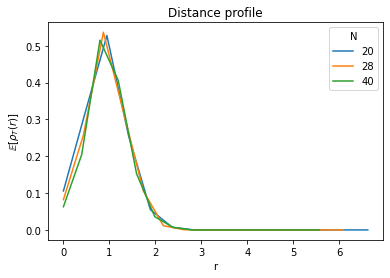

In [124]:
xs, ys = scale_profile(profiles, sizes, 0.25)
print(xs)
overlay_profiles(ys, xs)

# Finite size scaling

In [125]:
def profiles_max(profiles):
    profiles_max = np.max(profiles, axis=1)
    return profiles_max[:,0], profiles_max[:,1]

def power_fit(N, d, a):
    return a*N**d

def finite_size_scaling(profile):
    prof_max, sigma_max = profiles_max(profile)
    fit = curve_fit(power_fit, sizes, prof_max, p0=[0.75, 1])
    (d, a), err = fit
    d_H = 1/(1-d)
    d_err = np.sqrt(err[0,0])
    d_H_err = d_H**2*d_err
    a_err = np.sqrt(err[1,1])
    return d_H, d_H_err, a, a_err

40
52
68
90
120
d_H = 3.9632107072656733+/-d_H_err = 0.6009867825170181
a = 0.4833592398024546+/-a_err = 0.082425707395317


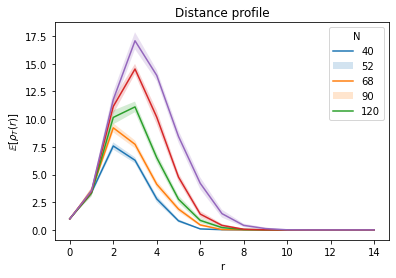

In [126]:
#fit a*exp(cx)*x**n for every size and compare
# overlay profiles!!!!!!!

beta=0
sizes = [2*int(i) for i in np.geomspace(20, 60, 5)]

prof = make_profiles(beta, sizes, strategy=['gravity', 'ising'])
d_H, d_H_err, a, a_err = finite_size_scaling(prof)

print(f'{d_H = }' +'+/-'+ f'{d_H_err = }')
print(f'{a = }'+'+/-'+ f'{a_err = }')

plot_profiles(prof)

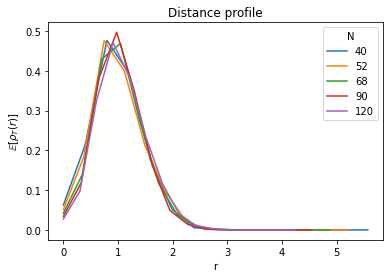

In [127]:
d = 4
xs, ys = scale_profile(prof, sizes, 1/d)
overlay_profiles(ys, xs)

40
52
68
90
120
d_H = 6.578665076224871+/-d_H_err = 1.9488057751919035
a = 0.3216267723305433+/-a_err = 0.06488964414664411


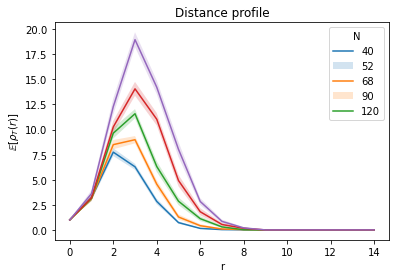

In [128]:
beta=0.2
sizes = [2*int(i) for i in np.geomspace(20, 60, 5)]

prof = make_profiles(beta, sizes, strategy=['gravity', 'ising'])
d_H, d_H_err, a, a_err = finite_size_scaling(prof)

print(f'{d_H = }' +'+/-'+ f'{d_H_err = }')
print(f'{a = }'+'+/-'+ f'{a_err = }')

plot_profiles(prof)

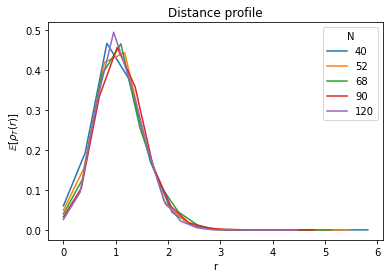

In [129]:
d = 4.2
xs, ys = scale_profile(prof, sizes, 1/d)
overlay_profiles(ys, xs)

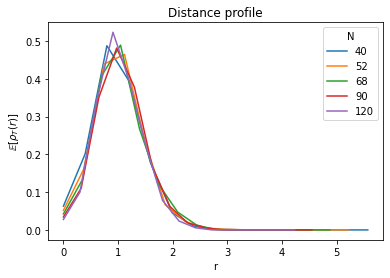

In [130]:
d = 4
xs, ys = scale_profile(prof, sizes, 1/d)
overlay_profiles(ys, xs)

In [131]:
np.random.normal(size=(2, 3))[1:]

array([[-0.31936808,  0.93005216, -1.47504701]])

In [132]:
l = Manifold(4)

In [133]:
ad = l.adj
ad = ad*2
print(l.adj)

[ 9  5  4  6  2  1  3 11 10  0  8  7]
